In [3]:
set.seed(123)

In [4]:
# Source data can be downloaded from the website:
# https://zenodo.org/record/1443566/files/real/gold/human-embryos_petropoulos.rds
trajectory.raw <- readRDS("../../dynverse/real/gold/human-embryos_petropoulos.rds")
# Structure of the raw data 
str(trajectory.raw)
expr_mat <- (trajectory.raw$expression)
str(expr_mat)

List of 21
 $ id                   : chr "real/gold/human-embryos_petropoulos"
 $ cell_ids             : chr [1:1289] "E3.1.443" "E3.1.444" "E3.1.445" "E3.1.447" ...
 $ cell_info            :'data.frame':	1289 obs. of  7 variables:
  ..$ cell_id                             : chr [1:1289] "E3.1.443" "E3.1.444" "E3.1.445" "E3.1.447" ...
  ..$ Source.Name                         : chr [1:1289] "E3.1.443" "E3.1.444" "E3.1.445" "E3.1.447" ...
  ..$ Characteristics.individual.         : chr [1:1289] "E3.1" "E3.1" "E3.1" "E3.1" ...
  ..$ Characteristics.organism.part.      : chr [1:1289] "embryo" "embryo" "embryo" "embryo" ...
  ..$ Characteristics.developmental.stage.: chr [1:1289] "embryonic day 3" "embryonic day 3" "embryonic day 3" "embryonic day 3" ...
  ..$ Characteristics.treatment.          : chr [1:1289] "No" "No" "No" "No" ...
  ..$ milestone_id                        : chr [1:1289] "embryonic day 3" "embryonic day 3" "embryonic day 3" "embryonic day 3" ...
 $ source               :

In [5]:
# pca and elbow fixing
expr_pca=prcomp(expr_mat, scale.  = F, retx = T)
library(PCAtools)
pca.dim <- findElbowPoint(expr_pca$sdev^2)

Loading required package: ggplot2
Loading required package: ggrepel
Loading required package: reshape2
Loading required package: lattice
Loading required package: cowplot

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘PCAtools’

The following objects are masked from ‘package:stats’:

    biplot, screeplot



In [6]:
# Endness calculation
source('../functionsV3.R')
str(expr_mat)
All_endv <- Endness_allpoints_paral(expr_mat, L = 1)

 num [1:1289, 1:8772] 15.5 14.2 15.5 14.4 12.6 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:1289] "E3.1.443" "E3.1.444" "E3.1.445" "E3.1.447" ...
  ..$ : chr [1:8772] "RN7SL1" "RPS4Y1" "KRT19" "CGA" ...



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: iterators
Loading required package: parallel


In [2]:
# saveRDS(object = All_endv, file = 'human-embryos_petropoulos.RDS')
# All_endv <- readRDS('human-embryos_petropoulos.RDS')
# range(All_endv)

[1] 0.1664728 0.9563943

[1] TRUE

# A tibble: 4 x 2
  from            to             
  <chr>           <chr>          
1 embryonic day 3 embryonic day 4
2 embryonic day 4 embryonic day 5
3 embryonic day 5 embryonic day 6
4 embryonic day 6 embryonic day 7


[1] 0.1664728 0.9563943

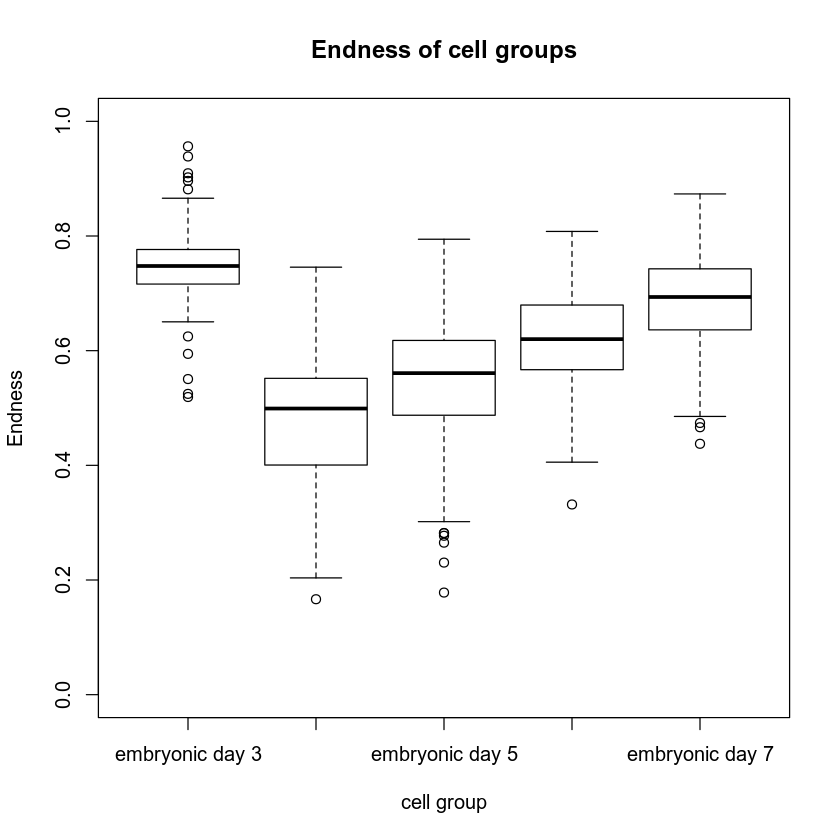

In [9]:
# Distribution of endnessin each Group
groups_cells <- trajectory.raw$prior_information$groups_id
# Examine the groups of each cell
identical(groups_cells$cell_id, rownames(expr_mat))
print(trajectory.raw$prior_information$groups_network)
boxplot(All_endv~groups_cells$group_id,xlab = 'cell group', ylab = 'Endness', main = 'Endness of cell groups'
       ,ylim = c(0,1))
range(All_endv)

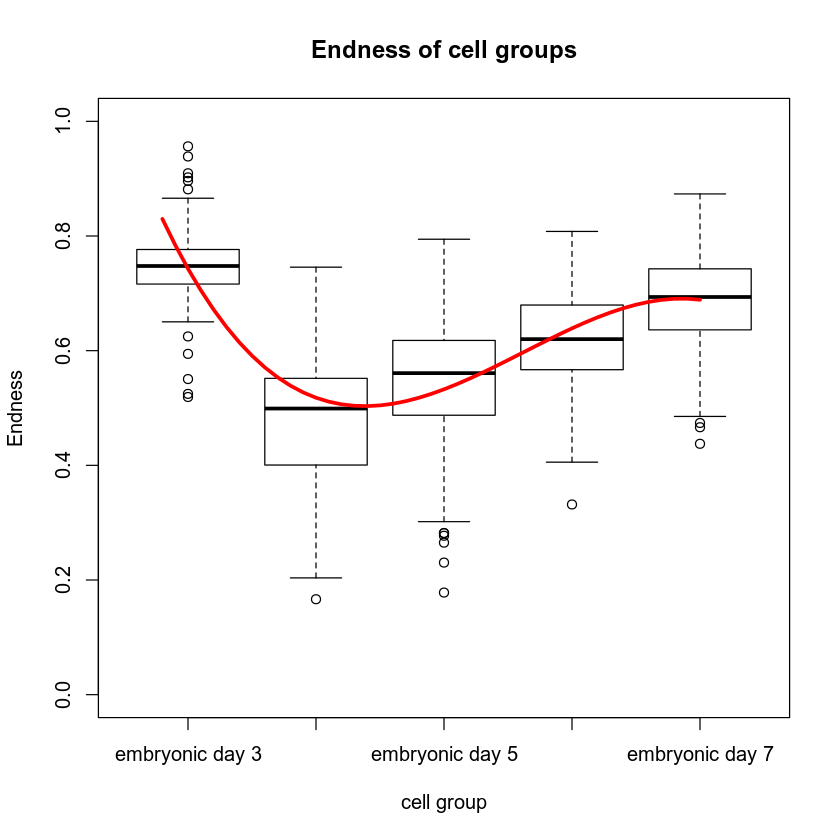

In [13]:
f <- boxplot(All_endv~groups_cells$group_id,xlab = 'cell group', ylab = 'Endness', main = 'Endness of cell groups'
       ,ylim = c(0,1)) # handle of the figure
medians <- f$stats[3,] # the median of endnesses
x <- 1:5
fit <- lm( medians~ x + I(x^2) + I(x^3)) # +I(x^4)) # polynomial curve fitting

newx <- seq(0.8,5.05,0.1) # new coordinates
newX <- cbind(rep(1,length(newx)), newx, newx^2, newx^3 )# ,  newx^4 )
newy <- newX %*% coef(fit) # newy for newx
lines(newx,newy,type = 'l',col = 'red',lwd = 3)

In [ ]:
library(igraph)
ct.graph <- graph_from_edgelist(as.matrix(trajectory.raw$prior_information$groups_network))
plot(ct.graph)

In [ ]:
# Calculate the endenss on the longest path
# Initilize the parameters:
select.point <- 0   # x0
data =  expr_mat   # X
k.nei =  10        # knei
fraction.l = 1     # L
FIG = F            # FIG

distMat <- base::as.matrix(dist(data, method="euclidean")) # distance matrix for the points, symmetric matrix

knnNei <- knnFinder(distMat,round(k.nei)) # find knn for each of the point

library(igraph)

G <- graph_from_data_frame(knnNei, directed = F)

simpG <- simplify(G, remove.loops = FALSE, edge.attr.comb = "mean")

distAll = distances(G, weights = NULL) #The distance beteen each node pair in the graph

# Step 2: find the intrinsic width in the point set X with respect the point id x0

intriWidth=c() # initialization

intriRadius = c() 

dist0 = distAll[select.point,]# The distance from each node to the start point x0

for(ii in seq(0, 1, 1/100 ) ){ #100 is the number of path points to calculate the intrinsic width

    iiSet = (dist0<= ii*max(distAll))

    iiWidth = max(distAll[iiSet, iiSet])

    intriWidth = c(intriWidth,iiWidth)

    iiRadius = max(dist0[iiSet])

    intriRadius = c(intriRadius, iiRadius)

}

vind <- !is.na(intriWidth/intriRadius) & intriRadius/max(distAll)<= L

library('pracma')

curveDv <- cbind((intriRadius/max(distAll))[vind], (intriWidth/intriRadius)[vind])

if(FIG){
plot(c(0, curveDv[,1]), c(1, curveDv[,2])
     , type = 'l'
     , xlim = c(0,1), ylim = c(1,2))

}

endv.select.point <- 2- trapz(c(0, curveDv[,1]), c(1, curveDv[,2]))/max(curveDv[,1])